In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5 #3x^2 - 4x + 5

In [3]:
f(3.0)

20.0

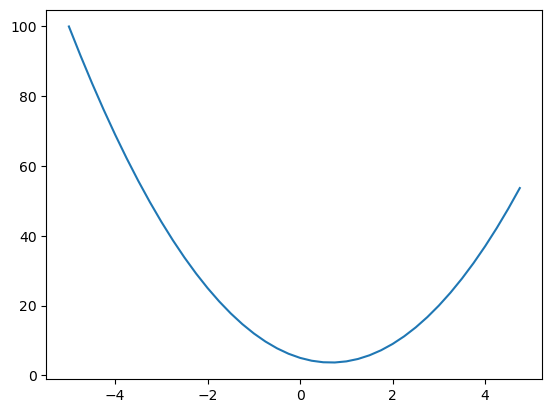

In [7]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [11]:
h = 0.0000001
x=3.0
(f(x+h) - f(x))/h #(f(x+h)-f(x)) is the rise, h is the run, so the slope is rise/run or (f(x+h)-f(x))/h

14.000000305713911

In [12]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [16]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c
print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.00002
slope 2.0000000000131024


In [120]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #holds the gradient
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += (other * (self.data ** (other-1))) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [8]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label = n._op)
            
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

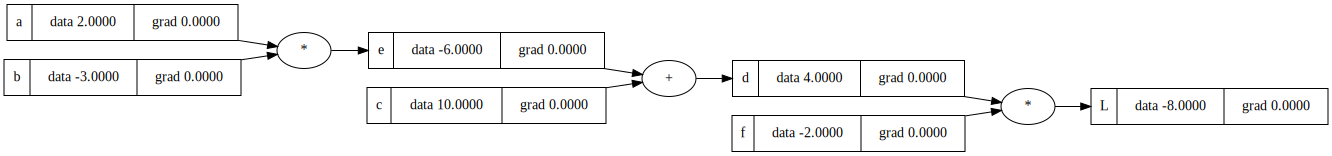

In [9]:
draw_dot(L)

In [ ]:
L = d*f 

#dL/dd = f
#dl/df = d

In [41]:
f.grad = 4.0
d.grad = -2.0

In [ ]:
#dl/dc = ?
#dl/de = ?

#d = c + e
#dd/dc = 1.0
#dd/de = 1.0

#dL/dc = (dL/dd) * (dd/dc)
#dL/de = (dL/dd) * (dd/de)

# We know:
#dL/dd
#dd/dc

In [42]:
c.grad = -2.0
e.grad = -2.0

In [30]:
#dL/de = -2.0

#dL/da = /
#dL/da = (dL/de) * (de/da)
#e = a*b
#de/da= b
#de/db = a
#dL/da = -2.0 * b
#dL/db = -2.0 * a

In [43]:
a.grad = 6.0
b.grad = -4.0

In [46]:
a.data += a.grad * 0.01
b.data += b.grad * 0.01
c.data += c.grad * 0.01
f.data += f.grad * 0.01

e = a*b
d = e + c
L = d*f
L.data

-7.286496

In [24]:
def lol():

    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

6.000000000021544


In [68]:
#Backprop through neuron
#inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias of neuron
b = Value(6.8813735870195432, label = 'b')
#synapses
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
#neuron total
n = x1w1x2w2 + b; n.label = 'n'
#output
o = n.tanh(); o.label = 'o'
o.backward()

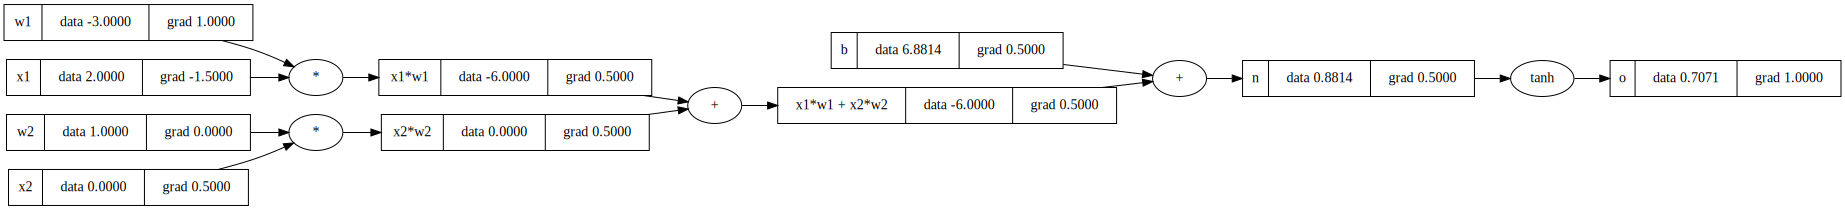

In [69]:
draw_dot(o)

In [70]:
o.backward() #big call

In [127]:
o.grad = 1.0
o._backward() #this calls the _backward function in the o variable and o is given this
#backward function when it is created from n's tanh(). Since the backward function is being declared in the way
#it is, the values are that of the creating variable, not the variable the ._backward() call
#is being made on. Ex: in this call, o is out and self.grad refers to n's grad.

In [76]:
# o = tanh(n)
#do/dn = 1 - o**2
n.grad = 1 - o.data**2

In [129]:
n._backward()

In [78]:
x1w1x2w2.grad = n.grad
b.grad = n.grad

In [130]:
b._backward()
x1w1x2w2._backward()

In [80]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [131]:
x1w1._backward()
x2w2._backward()

In [83]:
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [132]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

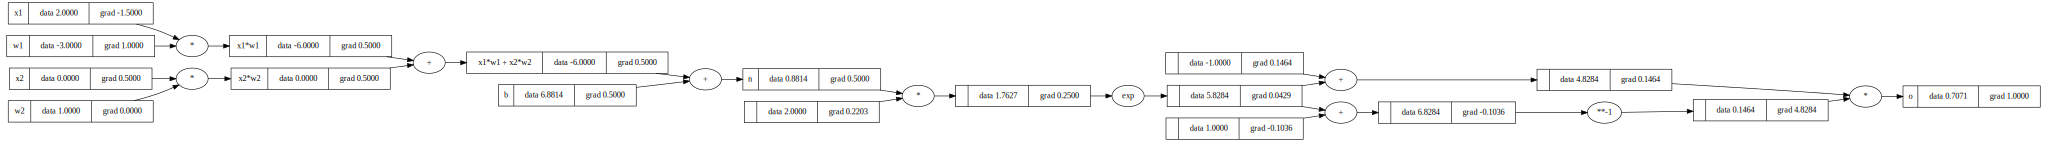

In [12]:
#Backprop through neuron
#inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias of neuron
b = Value(6.8813735870195432, label = 'b')
#synapses
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
#neuron total
n = x1w1x2w2 + b; n.label = 'n'
#output
#----
e = (2*n).exp()
o = (e-1)/(e+1)
#----
o.label = 'o'
o.backward()
draw_dot(o)

In [100]:
import torch

In [113]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o  = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [114]:
import random

In [135]:
class Neuron: 
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts #concatenate
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.5757284213278607)

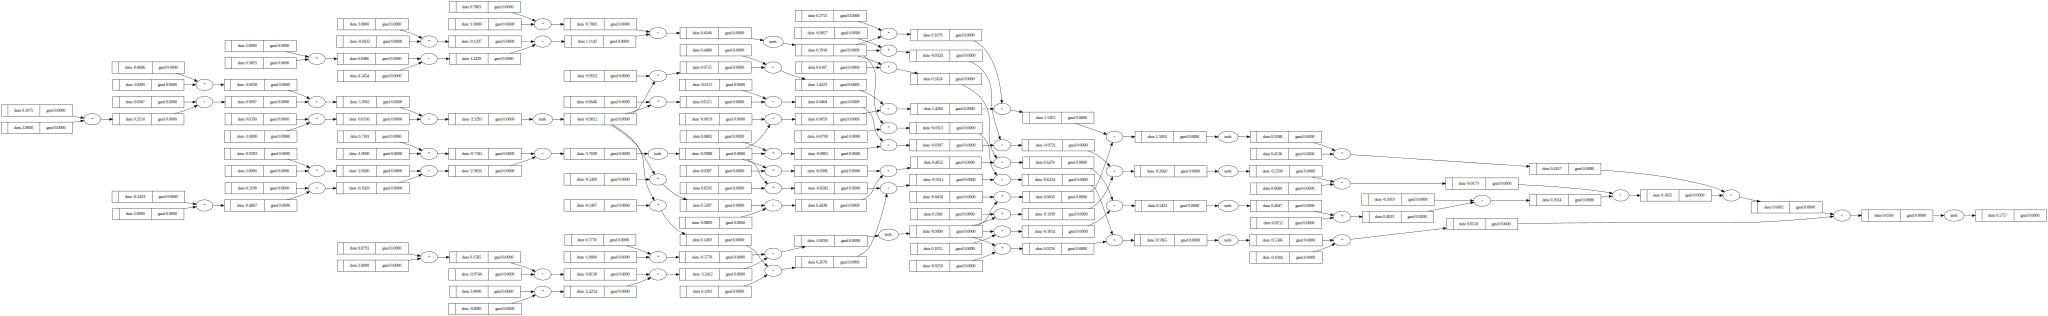

In [136]:
draw_dot(n(x))

In [137]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

[Value(data=0.5757284213278607),
 Value(data=-0.37335661718580904),
 Value(data=-0.048007806659314506),
 Value(data=0.3325767308772072)]

In [138]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.924431258041927)

In [213]:
for k in range(10):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    #backward pass
    for p in n.parameters(): #zero grad
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.01 * p.grad
    print(k, loss.data)

#we zero grad become otherwise we get the cumulative gradient from each step, not the current gradient for this step.

Value(data=1.1219485399982302e-17)

In [169]:
n.layers[0].neurons[0].w[0].grad

36.182538658376046

In [214]:
ypred

[Value(data=0.9999999999979078),
 Value(data=-0.9999999977037205),
 Value(data=-0.9999999975614395),
 Value(data=0.9999999999979164)]